In [1]:
import torch
from CNN_LSTM_MODEL import CNNLSTMDepthModel

#### LOADING TENSORS

In [2]:
X = torch.load("X_eeg_tf.pt")        # [B, C, F, T]
metadata = torch.load("eeg_metadata.pt")

print("Loaded X shape:", X.shape)
print("Metadata:", metadata)

Loaded X shape: torch.Size([207, 8, 10, 21])
Metadata: {'num_trials': 207, 'channels': 8, 'freq_bins': 10, 'time_bins': 21, 'sampling_rate': 125, 'window_sec': 10, 'freq_band': '4–13 Hz', 'preprocessing': 'parquet_chunked_session_buffered'}


#### CONFIGURING DEVICE

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = X.to(device)

#### MODEL INITIALIZATION

In [4]:
B, C, FREQ, TIME = X.shape

model = CNNLSTMDepthModel(num_channels=C)
model = model.to(device)

#### FEED INTO MODEL

In [5]:
logits = model(X)
print("Logits shape:", logits.shape)

Logits shape: torch.Size([207, 3])


#### EXTRACTING LATENT EMBEDDINGS

In [6]:
model.eval()

with torch.no_grad():
    Z = model.encode(X)   # [204, 128]

print(Z.shape)

torch.Size([207, 128])


#### CONVERTING EMBEDDINGS TO NumPy

In [7]:
Z_np = Z.cpu().numpy()

#### APPLYING CLUSTERING (KMeans, k = 3)

In [28]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(Z_np)

print(cluster_labels.shape)
print(np.bincount(cluster_labels))

(207,)
[68 62 77]


#### VISUALIZING CLUSTERS WITH **PCA**

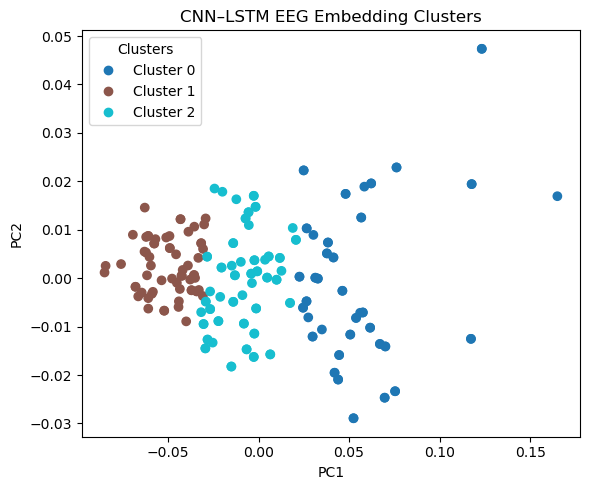

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
Z_2d = pca.fit_transform(Z_np)

plt.figure(figsize=(6,5))
scatter = plt.scatter(
    Z_2d[:,0],
    Z_2d[:,1],
    c=cluster_labels,
    cmap="tab10"
)

plt.title("CNN–LSTM EEG Embedding Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")

legend_handles, _ = scatter.legend_elements()
plt.legend(
    legend_handles,
    [f"Cluster {i}" for i in np.unique(cluster_labels)],
    title="Clusters"
)

plt.tight_layout()
plt.show()


#### Compute cluster-wise spectral averages

In [10]:
X_np = X.cpu().numpy()   # [N, C, F, T]
labels = cluster_labels

In [11]:
import numpy as np

unique_clusters = np.unique(labels)

cluster_spectral_means = {}

for k in unique_clusters:
    idx = labels == k
    
    # Mean over trials → [C, F, T]
    cluster_mean = X_np[idx].mean(axis=0)
    
    # Mean over time → [C, F]
    spectral_mean = cluster_mean.mean(axis=-1)
    
    cluster_spectral_means[k] = spectral_mean

    print(f"Cluster {k}: {idx.sum()} trials")


Cluster 0: 68 trials
Cluster 1: 62 trials
Cluster 2: 77 trials


#### VISUALISING CHANNEL-AVERAGE SPECTRAL

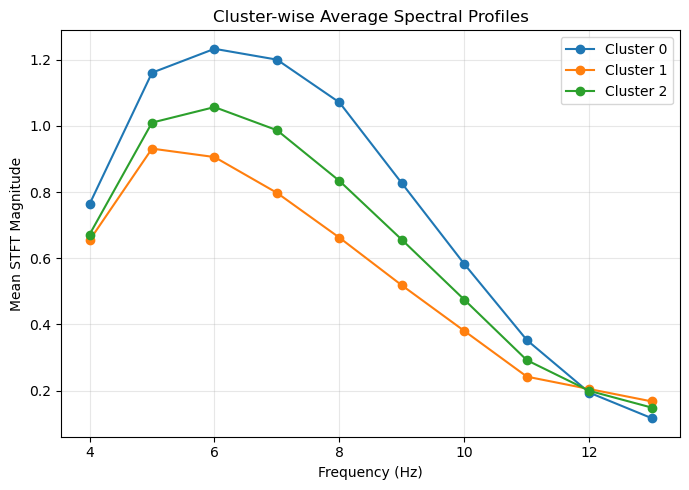

In [12]:
import matplotlib.pyplot as plt

freq_bins = np.linspace(4, 13, spectral_mean.shape[1])  # approximate

plt.figure(figsize=(7,5))

for k in unique_clusters:
    # Average over channels → [F]
    mean_spectrum = cluster_spectral_means[k].mean(axis=0)
    
    plt.plot(freq_bins, mean_spectrum, marker="o", label=f"Cluster {k}")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Mean STFT Magnitude")
plt.title("Cluster-wise Average Spectral Profiles")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### TRIAL-LEVEL SESSION IDs

In [13]:
from pathlib import Path
import numpy as np
import pyarrow.dataset as ds

In [14]:
def segment_trials_sessionwise_with_ids_parquet(
    parquet_file,
    eeg_channels,
    fs,
    window_sec=10,
    batch_size=200_000,
):
    samples_per_trial = fs * window_sec
    dataset = ds.dataset(parquet_file, format="parquet")

    session_buffers = {}        # sid → [C, N]
    trials = []
    trial_session_ids = []

    for batch in dataset.to_batches(batch_size=batch_size):
        df = batch.to_pandas()

        for sid in df["session_id"].unique():
            df_s = df[df["session_id"] == sid]
            eeg_chunk = df_s[eeg_channels].values.T  # [C, chunk_len]

            if sid not in session_buffers:
                session_buffers[sid] = eeg_chunk
            else:
                session_buffers[sid] = np.concatenate(
                    [session_buffers[sid], eeg_chunk], axis=1
                )

            # Emit full trials
            while session_buffers[sid].shape[1] >= samples_per_trial:
                trial = session_buffers[sid][:, :samples_per_trial]
                session_buffers[sid] = session_buffers[sid][:, samples_per_trial:]

                trials.append(trial)
                trial_session_ids.append(sid)

    return np.stack(trials), np.array(trial_session_ids)

In [15]:
RAW_DATA_PATH = Path("./Data_raw/")
PARQUET_FILE = RAW_DATA_PATH / "eeg_data.parquet"

EEG_CHANNELS = [
    "Fp1-A1", "Fp2-A2",
    "P3-A1", "P4-A2", "Pz-Aav",
    "O1-A1", "O2-A2",
    "Cz-Aav"
]

FS = 125

trials, trial_session_ids = segment_trials_sessionwise_with_ids_parquet(
    parquet_file=PARQUET_FILE,
    eeg_channels=EEG_CHANNELS,
    fs=FS,
    window_sec=10
)

print("Trials shape:", trials.shape)
print("Trial session IDs shape:", trial_session_ids.shape)

Trials shape: (207, 8, 1250)
Trial session IDs shape: (207,)


#### SAVING THE TRIAL SESSION IDs

In [16]:
trial_session_ids_t = torch.tensor(
    trial_session_ids,
    dtype=torch.long
)

torch.save(trial_session_ids_t, "trial_session_ids.pt")

print(
    "Saved trial_session_ids.pt with shape:",
    trial_session_ids_t.shape
)

Saved trial_session_ids.pt with shape: torch.Size([207])


#### CLUSTER AND SESSION CONTINGENCY TABLE

In [17]:
import pandas as pd

df_cs = pd.DataFrame({
    "cluster": cluster_labels,
    "session": trial_session_ids
})

contingency = pd.crosstab(df_cs["cluster"], df_cs["session"])
print(contingency)

session   0   1   2   3
cluster                
0        37   1  10  20
1        52   9   1   0
2        46  14  13   4


#### NORMALIZING FOR INTERPRETABILITY

In [18]:
contingency_norm = contingency.div(contingency.sum(axis=1), axis=0)
print(contingency_norm)

session         0         1         2         3
cluster                                        
0        0.544118  0.014706  0.147059  0.294118
1        0.838710  0.145161  0.016129  0.000000
2        0.597403  0.181818  0.168831  0.051948


#### CHI-SQUARE TEST

In [19]:
from scipy.stats import chi2_contingency

chi2, p_value, dof, expected = chi2_contingency(contingency)

print("Chi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("p-value:", p_value)

Chi-square statistic: 50.50968465832082
Degrees of freedom: 6
p-value: 3.715179041669119e-09


In [20]:
expected_df = pd.DataFrame(
    expected,
    index=contingency.index,
    columns=contingency.columns
)

print(expected_df)

session          0         1         2         3
cluster                                         
0        44.347826  7.884058  7.884058  7.884058
1        40.434783  7.188406  7.188406  7.188406
2        50.217391  8.927536  8.927536  8.927536


#### COMPUTING CHANNLE-WISE SPRECTRAL POWER PER CLUSTER

In [21]:
import numpy as np

X_np = X.cpu().numpy()        # [N, C, F, T]
labels = cluster_labels

# Average over frequency and time
# Result: [N, C]
X_channel_power = X_np.mean(axis=(2, 3))

In [22]:
unique_clusters = np.unique(labels)

cluster_channel_means = {}

for k in unique_clusters:
    idx = labels == k
    cluster_channel_means[k] = X_channel_power[idx].mean(axis=0)

#### VISUALISING CHANNEL-WISE COMPARISON

In [23]:
channel_names = [
    "Fp1", "Fp2",
    "P3", "P4", "Pz",
    "O1", "O2",
    "Cz"
]

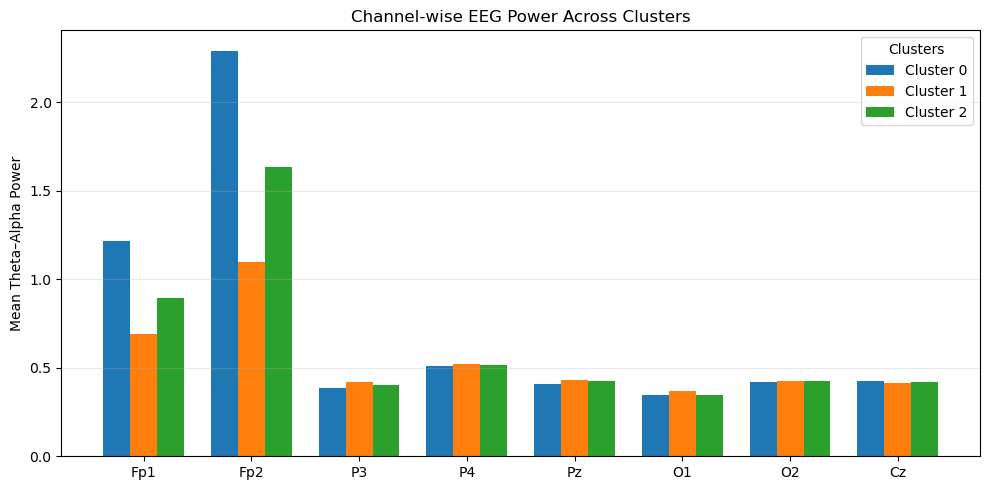

In [24]:
import matplotlib.pyplot as plt

x = np.arange(len(channel_names))
width = 0.25

plt.figure(figsize=(10,5))

for i, k in enumerate(unique_clusters):
    plt.bar(
        x + i * width,
        cluster_channel_means[k],
        width=width,
        label=f"Cluster {k}"
    )

plt.xticks(x + width, channel_names)
plt.ylabel("Mean Theta–Alpha Power")
plt.title("Channel-wise EEG Power Across Clusters")
plt.legend(title="Clusters")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

#### SAVING CLUSTERS AS PSEUDO LABLES

In [25]:
y_pseudo = torch.tensor(cluster_labels, dtype=torch.long)
torch.save(y_pseudo, "y_pseudo.pt")